In [2]:
%load_ext autoreload
%autoreload 2

In [31]:
import scipy
import numpy as np
np.set_printoptions(threshold=np.inf)
import matplotlib.pyplot as plt
import sympy

from pyiga import bspline, assemble, vform, geometry, vis, solvers, ieti, topology

#import importlib
#importlib.reload(pyiga.assemble)

In [32]:
# define discretization space (the same in each patch)
p = 3
kvs = 2 * (bspline.make_knots(p, 0.0, 1.0, 3),) # 15
c = 1

In [33]:
def enforce_same_derivatives(idx, side):
    """ Funtion to enforce the continuity in C^0 or C^1 across the patches in the ieti-dp method """
    if side == 0:
        return idx+1
    elif side == 1:
        return idx-1

Basis setup took 0.0017817020416259766 seconds
{0: [(35, 35)], 1: [(5, 35)], 2: [(30, 35)], 3: [(0, 35)]}
Ck   (0, 35)	-1.0
  (1, 29)	0.9999999999999998
  (1, 35)	-2.0
  (2, 34)	0.9999999999999998
  (2, 35)	-2.0


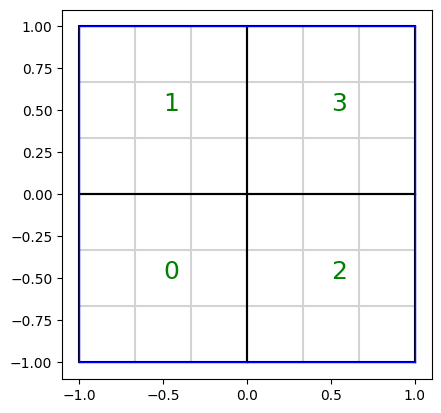

In [67]:
# define geometry
geos = [
    geometry.unit_square().translate((-1, -1)),
    geometry.unit_square().translate((-1, 0)),
    geometry.unit_square().translate((0, -1)),
    geometry.unit_square().translate((0, 0)),
]

patches = [(kvs, g) for g in geos]

# set up a PatchMesh object, which detects interfaces between patches
M = topology.PatchMesh(patches)
#bnd = M.outer_boundaries
#bnd0 = M.boundaries(0)

#print(bnd)
#print(bnd0)

# by default all outer boundaries are given the index 0, which we will use for the Dirichlet boundary
# let us generate a Neumann boundary indexed by 1
#M.set_boundary_id({0:{(0,0),(0,1),(1,0),(3,3)}})

# visualize the PatchMesh object with Dirichlet boundary (blue) and Neumann boundary (red)
M.draw(patch_idx = True, knots=True, bcolor={0:'blue',1:'red'})

# set up a MultiPatch object that initializes a Basis to map global dofs to local dofs
MP = assemble.Multipatch(M, automatch=True)
#MP.finalize()
    
#print(len(ifaces))
#print(ifaces[1])
#print(bspline.numdofs(kvs))
#print(local_to_global)

#B = ieti.jump_matrices(ifaces, MP.numdofs)
#print(B.shape)

# Constraint matrices for ieti-dp for each patch
cpp = MP.get_crosspoints()
print(cpp)

#print(MP.Constr1)
def construct_constraint_matrices():
    Ck = []
    for p in range(len(MP.mesh.patches)):
        loc, glob = cpp[p][0]
        
        nnz_per_row = MP.Constr1[:,loc+MP.N_ofs[p]].getnnz(axis=1)
        result = np.where(nnz_per_row > 0)[0]
        
        ck = MP.Constr1[result,MP.N_ofs[p]:MP.N_ofs[p+1]]
        #ck = ck[:int(ck.shape[0]/2),:]
        
        q,r = np.linalg.qr(ck.todense().T)
        ck = ck[np.abs(np.diag(r))>=1e-10]
        
        if p == 0:
            print("Ck", ck)
        
        Ck.append(ck)

    return Ck, scipy.sparse.block_diag(Ck)
        

Ck, C = construct_constraint_matrices()
#print(C)
#C = ieti.constraint_matrices(ifaces)    

In [68]:
# source term f and Dirichlet boundary function g
f = lambda x, y: 1
gN = lambda x,y: 0 

# set up Dirichlet boundary conditions
bcs = MP.compute_dirichlet_bcs({0:gN})

# assemble the linear system
Ak = [assemble.assemble('tr(hess(u)) * tr(hess(v)) * dx', kvs, bfuns=[('u',1), ('v',1)], geo=g) for g in geos]
#A_grad = assemble.assemble('inner(grad(u), grad(v)) * dx', kvs, bfuns=[('u',1), ('v',1)], geo=geo)
A = scipy.sparse.block_diag(Ak, format='csr')

params = {'f' : f, 'g' : gN}
rhs = [assemble.assemble('f * v * dx', kvs, params, bfuns=[('v',1)], geo=g).ravel() for g in geos]
# generate Neumann vector for global contribution to the right hand side, in this case it is a zero vector since g1 is zero
N = MP.assemble_surface('g1 * inner(grad(v),n) * ds', arity=1, g1=gN, boundary_idx=0)

#rhs += assemble.assemble('g * inner(grad(v),n) * ds', kvs, params, bfuns=[('v',1)], geo=geo, boundary=[1]).ravel()
rhs = np.hstack(rhs)

assert A.shape[1] == rhs.shape[0], "Size of rhs is different to size of the matrix"


# Other method for assembly
#def bilinear():
#    vf = vform.VForm(2)
#   u, v = vf.basisfuns()
#    vf.add(vform.tr(vform.hess(u)) * vform.tr(vform.hess(v)) * vform.dx)
#    return vf

#a = bilinear()

In [69]:
def construct_primal_basis(Ak, Ck):
    Psi = []
    for k in range(len(Ak)):
        a = Ak[k]
        c = Ck[k]
        AC = scipy.sparse.bmat(
        [[a, c.T],
         [c,  None   ]], format='csr')
        RHS = np.vstack([np.zeros((a.shape[0],c.shape[0])), np.ones((c.shape[0], c.shape[0]))])
        psi = scipy.sparse.linalg.spsolve(AC, RHS)
        print(psi.shape)
        psi, delta = psi[:a.shape[0],], psi[a.shape[0]:,]
        
        Psi.append(psi)
        
    return Psi

In [77]:
Psik=construct_primal_basis(Ak, Ck)

PSI = scipy.sparse.bmat([[Psik[0], None, None, None],
                         [None, Psik[1], None, None],
                         [None, None, Psik[2], None],
                         [None, None, None, Psik[3]]], format='csr')

PTAP = PSI.T@A@PSI

(39, 3)
(39, 3)
(39, 3)
(39, 3)
(12, 12)


In [ ]:
# set up and solve linear system
A_ieti = scipy.sparse.bmat(
    [[A, B.T],
     [B,  None   ]], format='csr')

rhs = np.hstack((rhs, np.zeros(B.shape[0],)))

LS = assemble.RestrictedLinearSystem(A_ieti, rhs, bcs)

u = LS.complete(solvers.make_solver(LS.A, spd=True).dot(LS.b))

# restrict solution to each individual patch
u_funcs = [geometry.BSplineFunc(kvs, MP.global_to_patch(p) @ u)
           for p in range(len(patches))]


In [ ]:
plt.figsize=(8,6)
fig, axs = plt.subplots(1, 1)

for (u_func, (kvs, geo)) in zip(u_funcs, patches):
    vis.plot_field(u_func, geo, vmin=0, vmax=1.5e-1)
axs.axis('scaled')
plt.colorbar();